<h1 style="background-color: #8EBAD9;
            font-size: 2.5em;
            color: #03112A;
            border-radius: 25px;
            text-align: center;
            padding: 20px;
            font-family: 'Verdana', sans-serif;
            box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);">
   <span style="font-weight: bold;"> Part 3: Bayesian Analysis for Arrivals rate using Gaussian Process Regression.</span>
</h1>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl" style="text-align: right;">
<strong>מגישים : </strong> <br>
 רז אלבז <br>
 נועה ענקי

#### קבוצה : 16

#### Git Link :

<div style="text-align: right;">
    <a href="https://github.com/Razelbaz1/Bayesian_models_project" target="_blank">
        קישור לכל הפרויקט ב - GitHub
    </a>
</div>


In [1]:
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import pymc as pm
import arviz as az
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm
from collections import defaultdict
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel, ConstantKernel as C
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Mounted at /content/drive


# ER analysis

### You are now incharge of the a queueing system in the ER, which operates 24/7.

### Patients are arriving with time-dependant rate. The service rate on the other is constanst at 15 patients per hour. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different arrival rate.

### We wish to analyze the expceted number of pateints in the ER as function of time. We have an event log of customers arriving to the ER and departing the ER. We have data collection of 1000 days.

### The data is a dictionary of 1000 different days numbered from 0 to 999. Each one is an event log of a different day.

### The columns of the data are:
#### 1. Customer_id - identifier of the arriving customer
#### 2. Time-stamp  - the time the event occurs. The units are in hours. The $i^{th}$ hour is the number of hours elapsed since 0:00 of that day.
#### 3. Type - event type, Arrival or Departure.
#### 4. num_cust - number of cusotmers in the system
#### 5. day - a numerical value of the day: {0: Sunday, 1: Monday, 2: Tuesday, 3: Wednesday, 4: Thursday, 5: Friday, 6: Shabbat}
#### 6. hour - the hour of the day, an integer from 0 to 23. If it is 0 then the hour is between midnight to 01:00.
#### 7. day_name - the name of the day of the week.


## Each day starts with 0 patients at 0:00.

# The goal of this task is to find the arrival rate for each hour of the day.

## From the data, one can use classic stastical methods in order to estimate the arrival rate for each hour of the week. The problem is that there is missing data, we do not have the data in the event log for all hours.

### The main idea is to estimate the arrival rate for time zones in which we have data and then using GP regression for time zones the data was missing.

### This part is split into three parts.


In [2]:
event_log_single_ser = pkl.load(open('/content/drive/MyDrive/Colab Notebooks/Base_project/event_log_part_2.pkl', 'rb'))

In [3]:
event_log_single_ser[0].head()

,Customer_id,Time_stamp,Type,num_cust,day,hour,day_name
0,1,0.006849,Arrival,1,0,0,Sunday
1,1,0.030546,Departure,0,0,0,Sunday
2,2,0.080376,Arrival,1,0,0,Sunday
3,2,0.113483,Departure,0,0,0,Sunday
4,3,0.295239,Arrival,1,0,0,Sunday


In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

##############################################
###### Funcitons #############################
##############################################

def model(n, t, lambda_t, mu):
    """
    Differential equation for the M(t)/M/1 queue:
    dn/dt = lambda(t) - mu * (1 - p0(t))
    where p0(t) is the probability of 0 customers in the system.

    For approximation, we use the relation p0 ≈ max(0, 1 - n) when n < 1
    and p0 ≈ 0 when n ≥ 1.
    """
    # Current arrival rate based on time
    current_lambda = piecewise_lambda(t, lambda_t)

    # Approximate p0
    if n < 1:
        p0 = max(0, 1 - n)
    else:
        p0 = 0

    dndt = current_lambda - mu * (1 - p0)
    return dndt

def piecewise_lambda(t, lambda_t):
    """
    Returns the arrival rate at time t based on piecewise constant definition.
    lambda_t is a list of tuples (start_time, end_time, rate)
    """
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0  # default if outside all intervals


def compute_MSE(n_true, n):
  return ((n_true - n)**2).mean().item()


def create_tuples(df_sorted):

    all_tuples =  []
    for row_ind in range(df_sorted.shape[0]):
        hour = df_sorted.loc[row_ind, 'hour']
        day = df_sorted.loc[row_ind, 'day']
        rate = df_sorted.loc[row_ind, 'rate'].item()
        tot_time = hour + 24*day
        all_tuples.append((tot_time.item(),tot_time.item()+1, rate))

    return all_tuples


def plot_results(df_res, n_true):

  # Parameters
    mu = 15.0  # service rate
    all_tuples = create_tuples(df_res)
    lambda_t = all_tuples  #[(0, 10, 5.0), (10,30,1) ,(30, 50, 0.2)]  # piecewise arrival rates
    # lambda_t_true = all_tuples_true

    # Time points
    t = np.linspace(0, 168, 1000)

    # Initial condition: empty system
    n0 = 0.0
    n = create_tuples(df_res)
    # Solve the ODE
    n = odeint(model, n0, t, args=(lambda_t, mu))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(t, n, '-', color = 'orange', linewidth=2, label = 'Predicted')
    plt.plot(t, n_true,  linewidth=2, label = 'True', linestyle = '--')
    plt.xlabel('Time')
    plt.ylabel('Number of customers in system')
    plt.title('Queue analysis')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Expected number of customers in system')
    plt.grid(True)

    print('The MSE is: ', compute_MSE(n_true, n))



    plt.show()

## Part 1:

### Tasks:

### 1. Do Bayesian anaysis for the number of arriving customers and its distirbution for the Sunday between 0:00 to 1:00.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average arrival prediction?

### 5. What is the estimated arrival rate? Give a single values based on the posterior.


In [ ]:
# Load the dataset
with open("event_log_part_2.pkl", "rb") as f:
    data_dict = pkl.load(f)

# Step 1: Extract arrival events on Sunday (day=0) between 00:00–01:00 (hour=0)
arrival_counts_sunday_00 = []

for day_df in data_dict.values():
    subset = day_df[(day_df["day"] == 0) & (day_df["hour"] == 0) & (day_df["Type"] == "Arrival")]
    arrival_counts_sunday_00.append(subset.shape[0])

arrival_counts_sunday_00 = np.array(arrival_counts_sunday_00)




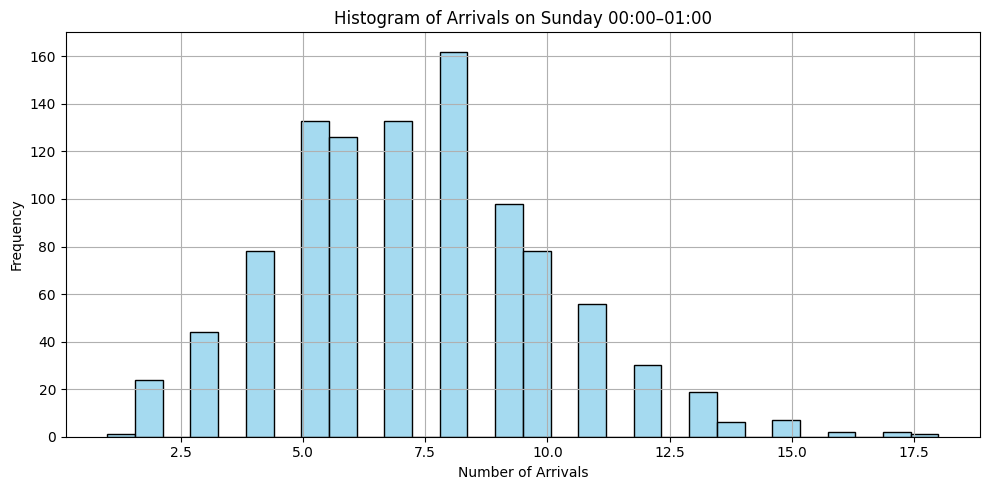

In [ ]:
# Step 2: Describe the data
mean_val = arrival_counts_sunday_00.mean()
std_val = arrival_counts_sunday_00.std()
min_val = arrival_counts_sunday_00.min()
max_val = arrival_counts_sunday_00.max()
unique_counts = np.unique(arrival_counts_sunday_00, return_counts=True)

# Prepare summary
summary_stats = {
    "mean": mean_val,
    "std": std_val,
    "min": min_val,
    "max": max_val,
    "num_days": len(arrival_counts_sunday_00)
}#)


# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(arrival_counts_sunday_00, bins=30, kde=False, color='skyblue')
plt.title("Histogram of Arrivals on Sunday 00:00–01:00")
plt.xlabel("Number of Arrivals")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display unique counts and summary
df_unique = pd.DataFrame({
    "arrival_count": unique_counts[0],
    "frequency": unique_counts[1]
})

In [ ]:
summary_stats

{'mean': np.float64(7.299),
 'std': np.float64(2.724261184247942),
 'min': np.int64(1),
 'max': np.int64(18),
 'num_days': 1000}

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
<div dir="rtl">
    
### Part 1 – Bayesian analysis for arrivals on Sunday 00:00–01:00
   
</div>

<div dir="rtl">
בשלב הראשון נבצע ניתוח תיאורי של מספר ההגעות בכל אחד מ־1000 השבועות בשעה שבין 00:00 ל־01:00 ביום ראשון.

- תחילה שלפנו את כלל האירועים מסוג **Arrival** המתרחשים בשעה `hour = 0` וביום `day = 0`.
- ספרנו, עבור כל יום, כמה לקוחות הגיעו בפרק זמן זה.
- ממוצע ההגעות לשעה זו לאורך כל השבועות: **7.3** לקוחות.
- סטיית התקן: **2.72**.
- הערכים נעים בין **1** ל־**18** לקוחות.
- בהתפלגות, ניתן לראות כי רוב הימים מכילים בין 5 ל־10 הגעות.
</div>

<div dir="rtl">
לא נמצאו ערכים קיצוניים קיצוניים או חריגות חריפות, כך שניתן להשתמש בהתפלגות פואסון כמודל הסתברותי רלוונטי.

</div>

<div dir="rtl">
    
#### בחירת פונקציית הלייקלי-הוד (Likelihood function) <br>

</div>

In [ ]:
with pm.Model() as model_poisson:

    # Prior: Gamma distribution for the rate λ
    λ = pm.Gamma("λ", alpha=2.0, beta=1.0)

    # Likelihood: Poisson distribution for the observed arrival counts
    obs = pm.Poisson("obs", mu=λ, observed=arrival_counts_sunday_00)


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl">

### למה בחרנו בגמא כפריור ל־λ?

<div dir="rtl">

<div>
בחרנו להשתמש בהתפלגות Gamma כפריור לפרמטר λ מהסיבות הבאות:


1. התחום שלה חיובי בלבד – כמו λ של פואסון.
2. היא הפריור הקונגוגטי של פואסון – כלומר הפוסטריור שלה גם גמא, מה שמפשט את החישוב.
3. יש לה שני פרמטרים (α, β) שנותנים שליטה על התוחלת והשונות.
4. זו בחירה מקובלת ביישומים של ספירה בזמן (כמו Arrival rate).
</div>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl">

### למה בחרנו בהתפלגות פואסון בפונקציית Likelihood ?
בחרנו להשתמש בהתפלגות **Poisson** כלייקלי-הוד מכיוון שמדובר בספירת אירועים בדידים (הגעות ל־ER) בפרק זמן קבוע (שעה). מודל זה מתאר היטב תהליך של אירועים אקראיים המתרחשים בקצב קבוע.
בשלב הבא נבנה את המודל הבייסיאני בעזרת `PyMC` תוך שימוש בפריור מתאים ל־λ (למשל, Gamma) והגדרת ההתפלגות הפואסונית כלייקלי-הוד.
</div>

In [ ]:
# Empirical data
observed_counts = arrival_counts_sunday_00

# Building the model
with pm.Model() as model:
    λ = pm.Gamma("λ", alpha=2, beta=1)  # Prior to Lambda
    obs = pm.Poisson("obs", mu=λ, observed=observed_counts)  # Likelihood

    trace = pm.sample(2000, tune=1000 , return_inferencedata=True) # , target_accept=0.95

    # Posterior predictive samples
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs"], random_seed=42)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 356 seconds.
Sampling: [obs]


Output()

array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>]],
      dtype=object)

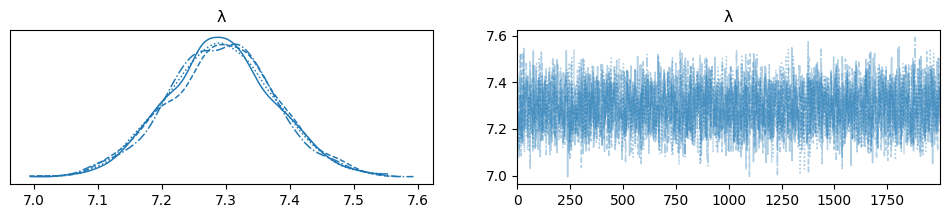

In [ ]:
az.plot_trace(trace, var_names=["λ"])

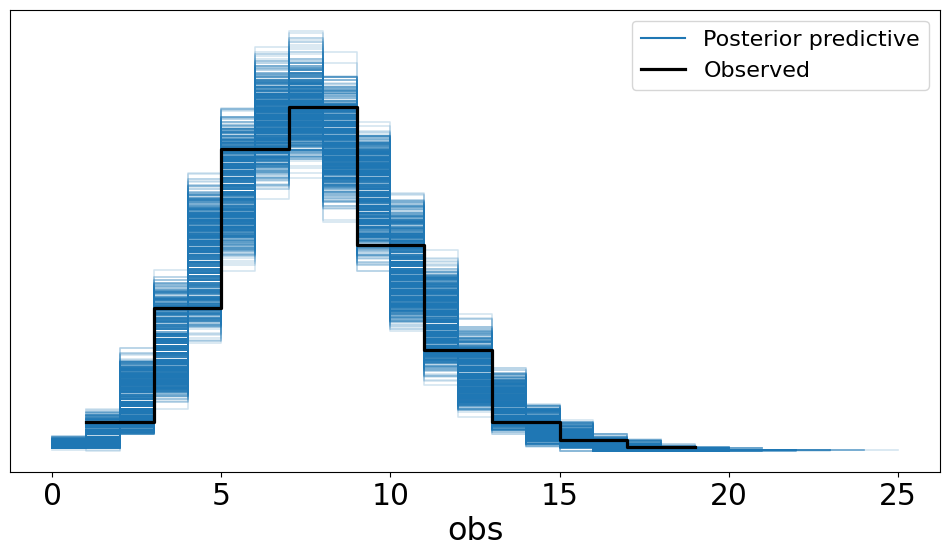

In [ ]:
ax = az.plot_ppc(ppc, num_pp_samples=1000, figsize=(12, 6), mean=False)

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl">

### 🔍 שאלה 3 - בדיקת התאמה של מודל באמצעות Posterior Predictive Check

לאחר שבנינו את המודל הבייסיאני עם פונקציית לייקלי־הוד מסוג פואסון, ביצענו בדיקה גרפית מסוג Posterior Predictive Check (PPC) על מנת לבדוק עד כמה ההתפלגות שחוזה המודל מתאימה לנתונים האמיתיים שנצפו.

</div>


<Axes: title={'center': 'λ'}>

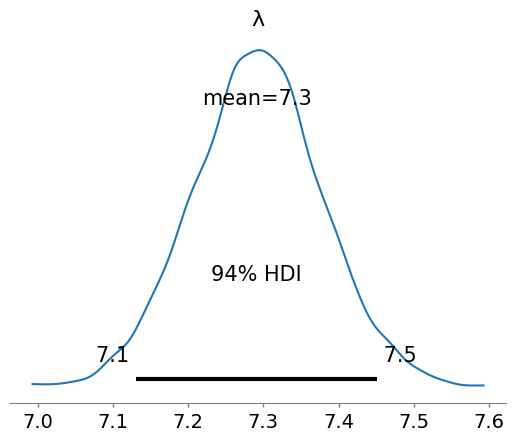

In [ ]:
az.plot_posterior(trace, var_names=["λ"])


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl">

### 🔍 שאלה 4 – מידת הוודאות של התחזית הממוצעת (λ)

בגרף שלהלן מוצגת ההתפלגות הפוסטריורית של פרמטר λ – קצב ההגעה לשעה 00:00–01:00 ביום ראשון.

#### ✨ תובנות מהגרף:
- ממוצע הפוסטריור של λ הוא **7.3 לקוחות לשעה**.
- תחום האמינות ברמת 94% (HDI – Highest Density Interval) נע בין **7.1 ל־7.5**.
- ההתפלגות חדה ומרוכזת סביב הממוצע, מה שמעיד על **מידת ודאות גבוהה** של המודל לגבי התחזית.

#### 🧠 מסקנה:
בהתבסס על ההיסטוגרמה וה־HDI הצר, ניתן לקבוע שהמודל **סבור בביטחון גבוה** שקצב ההגעה (λ) בשעה זו ביום ראשון נע סביב הערך 7.3. זהו חיזוי מהימן שניתן להשתמש בו להמשך הניתוח בפרק הבא.
</div>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl">

### שאלה 5 – אומדן נקודתי לקצב ההגעה (λ)

</div>

<div dir="rtl">
<div>
בשלב זה אנחנו מתבקשים לספק ערך בודד שמייצג את אומדן קצב ההגעה למיון (λ), בהתבסס על ההתפלגות הפוסטריורית שהתקבלה.
<div>
</div>
    
<div dir="rtl">

#### אפשרויות לבחירה:
- **Mean (ממוצע)** – הערך הממוצע של הדגימות מהפוסטריור.
- **Median (חציון)** – הערך שמחלק את הפוסטריור ל־50% נמוך ו־50% גבוה.
- **Mode / MAP** – הערך שבו הפוסטריור מגיע לשיאו (Maximum A Posteriori).

<div>

<div dir="rtl">

#### הבחירה שלנו:

במקרה שלנו, הפוסטריור נראה סימטרי ומרוכז היטב (לפי הגרף בשאלה הקודמת), ולכן הבחירה ב־**ממוצע הפוסטריור** היא טבעית ונכונה.

<div dir="rtl">
    
> **λ ≈ 7.3 לקוחות בשעה** <br>
</div>

זהו קצב ההגעה המשוער למיון בשעת הלילה הראשונה של יום ראשון, כפי שנאמד ממודל בייסיאני על סמך הנתונים.

</div>


## Part 2:
### We have 24 hours a day, 7 days a week. In total we have a grid of 168 cells.

### We wish to map the average arrival rate at each time cell.

### In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid.

## Tasks:

### 1. Extract the arrival rate (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use GP regression for completing the average arrival time for the rest of the grid.
### 3. Plot on a 3D plot which contains:
#### a. Scatter plot of the data that was esitmated from data.
#### b. Scatter plot of the data that was esitmated from GP regression.
#### c. Surface plot of the GP regression.

### 4. What is the probability that the arrival rate between 18:00 to 19:00, on Shabbat, will be between 9 to 10 pateints per hour?
### 5. Please give full specification of the Gauusian distribution of the arrival rate on Monday between 18:00 to 19:00 and Monday between 19:00 to 20:00.
### 6. What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 08:00 to 09:00?
### What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 19:00 to 20:00?
### Which correlation value is larger? does this result make sense?

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

### שלב ראשון: מיפוי קצב ההגעה הממוצע לכל תא בזמן (שעה × יום)

בשלב זה מטרתנו הייתה להעריך את קצב ההגעה הממוצע של מטופלים ל־ER עבור כל שעה ביממה וכל יום בשבוע, כלומר עבור כל אחד מ־168 התאים ברשת (7 ימים × 24 שעות).

#### הגדרות:
- נסמן את \\( \lambda_{d,h} \\) בתור קצב ההגעה הממוצע של מטופלים ביום \\( d \in \{0,1,\dots,6\} \\) ובשעה \\( h \in \{0,1,\dots,23\} \\).
- עבור כל זוג \\( (d, h) \\), נשתמש בכל שבועות התצפית בהם קיימים נתונים לזמן הזה כדי לחשב את \\( \lambda_{d,h} \\) כ־**ממוצע מספר ההגעות** באותה שעה ויום לאורך כל השבועות.

#### שלבי הפעולה:
1. טענו את מבנה הנתונים שהוא `dictionary` של 1000 שבועות. כל ערך במילון הוא `DataFrame` שמתאר יומן אירועים יומי של שבוע מסוים.  
2. סיננו מתוך כל שבוע רק את רשומות ההגעה (`Type == "Arrival"`).  
3. קיבצנו לפי \\( (day, hour) \\) וספרנו כמה הגעות היו לכל זוג כזה בשבוע.  
4. שמרנו את מספר ההגעות לכל זוג \\( (day, hour) \\) לאורך כל השבועות.  
5. לבסוף, חישבנו את הקצב הממוצע לכל זוג \\( (d, h) \\) באמצעות הנוסחה הבאה:

\\[
\lambda_{d,h} = \frac{1}{N_{d,h}} \sum_{i=1}^{N_{d,h}} x^{(i)}_{d,h}
\\]

<div dir="rtl"
    
**כאשר**:
- \\( x^{(i)}_{d,h} \\) הוא מספר ההגעות בשבוע ה־\\( i \\) בזמן \\( (d,h) \\).
- \\( N_{d,h} \\) הוא מספר השבועות שבהם קיימים נתונים לזמן זה.

#### תוצאה:
<div dir="rtl"
    
קיבלנו מטריצה בגודל \\( 7 \times 24 \\), כאשר כל תא מכיל את \\( \lambda_{d,h} \\).  
תאים בהם לא נרשמו הגעות באף שבוע נותרו עם ערך `NaN`.
<div dir="rtl"
    
השלב הבא יהיה **להשלים תאים חסרים** באמצעות מודל רגרסיה גאוסי (Gaussian Process Regression).
<div>
</div>


In [4]:
with open("/content/drive/MyDrive/Colab Notebooks/Base_project/event_log_part_2.pkl", "rb") as f:
    data_dict = pkl.load(f)

# Dictionary where the key is (day, time) and the value is a list of arrival counts
arrival_counts_by_cell = defaultdict(list)

# Go through all the weeks (each df in the dictionary)
for week_df in data_dict.values():
    # Filter only the arrival rows
    arrivals = week_df[week_df["Type"] == "Arrival"]

    # Group by (day, hour) and count how many arrivals there were in each group
    grouped = arrivals.groupby(["day", "hour"]).size()

    # Add each result to the dictionary
    for (day, hour), count in grouped.items():
        arrival_counts_by_cell[(day, hour)].append(count)


In [5]:
# Convert the data to a table of averages (DataFrame of size 7×24)
arrival_rate_matrix = pd.DataFrame(index=range(7), columns=range(24), dtype=float)

for (day, hour), counts in arrival_counts_by_cell.items():
    arrival_rate_matrix.loc[day, hour] = sum(counts) / len(counts)


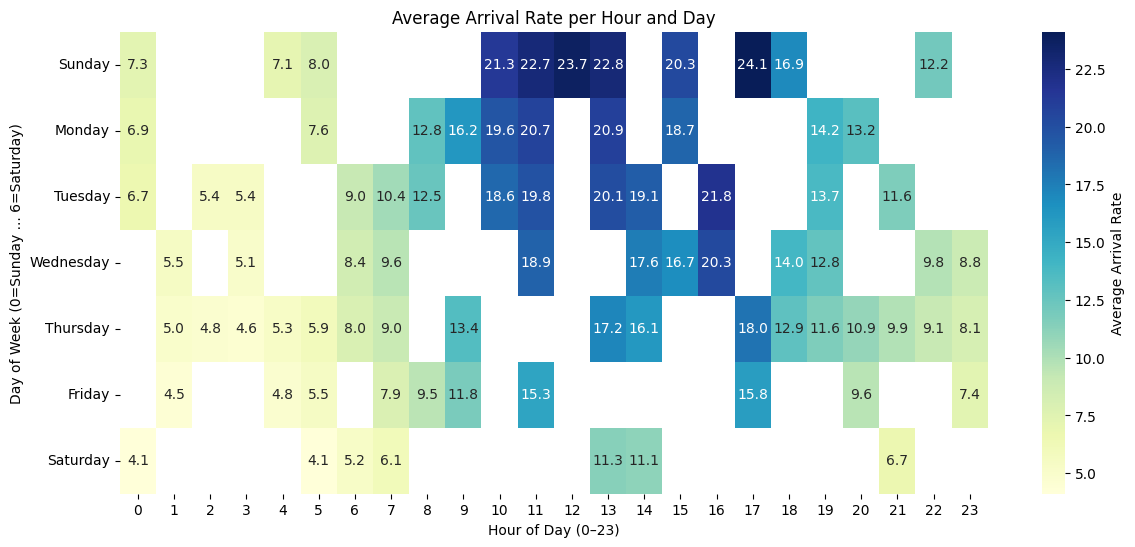

In [6]:
plt.figure(figsize=(14, 6))
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
arrival_rate_matrix_plot = arrival_rate_matrix.copy()
arrival_rate_matrix_plot.index = weekday_names

sns.heatmap(arrival_rate_matrix_plot, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={"label": "Average Arrival Rate"})
plt.title("Average Arrival Rate per Hour and Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Day of Week (0=Sunday ... 6=Saturday)")
plt.show()


In [7]:
arrival_rate_matrix.isna().sum().sum()

np.int64(88)

In [8]:
# Flatten known data for training
known_points = []
known_values = []

for day in range(7):
    for hour in range(24):
        if not pd.isna(arrival_rate_matrix.loc[day, hour]):
            known_points.append([day, hour])
            known_values.append(arrival_rate_matrix.loc[day, hour])

X_known = np.array(known_points)
y_known = np.array(known_values)

# Locations to predict (missing cells)
missing_points = []
missing_indices = []

for day in range(7):
    for hour in range(24):
        if pd.isna(arrival_rate_matrix.loc[day, hour]):
            missing_points.append([day, hour])
            missing_indices.append((day, hour))

X_missing = np.array(missing_points)

from sklearn.gaussian_process.kernels import (RBF,RationalQuadratic,DotProduct,WhiteKernel,Matern,)

# We'll define kernel candidates with tuned parameter ranges
kernel_configs = {
    "RBF": RBF(length_scale=1.0),
    "RationalQuadratic": C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    "DotProduct": DotProduct(sigma_0=1.0),
    "WhiteKernel": WhiteKernel(noise_level=1.0),
    "Matern_3/2": C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5),
    "Matern_5/2": C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5),
}

# Load n_true for future use
n_true_pkl = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Base_project/n_true.pkl")
n_true_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Base_project/n_true.csv")

# Store both to check consistency
n_true_arr = n_true_pkl if isinstance(n_true_pkl, np.ndarray) else n_true_pkl.values

# Store results
kernel_results = {}
res_matrices = {}



In [9]:
# Placeholder — plot_results will be used later with df_res
from scipy.integrate import odeint

def model(n, t, lambda_t, mu):
    current_lambda = piecewise_lambda(t, lambda_t)
    p0 = max(0, 1 - n) if n < 1 else 0
    return current_lambda - mu * (1 - p0)


def piecewise_lambda(t, lambda_t):
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0


def compute_MSE(n_true, n):
    return ((n_true - n) ** 2).mean().item()


def create_tuples(df_sorted):
    all_tuples = []
    for row_ind in range(df_sorted.shape[0]):
        hour = df_sorted.loc[row_ind, "hour"]
        day = df_sorted.loc[row_ind, "day"]
        rate = df_sorted.loc[row_ind, "rate"].item()
        tot_time = hour + 24 * day
        all_tuples.append((tot_time.item(), tot_time.item() + 1, rate))
    return all_tuples


def calc_predicted_n_and_mse(df_res, n_true):
    mu = 15.0
    all_tuples = create_tuples(df_res)
    t = np.linspace(0, 168, 1000)
    n0 = 0.0
    n = odeint(model, n0, t, args=(all_tuples, mu))
    return compute_MSE(n_true, n)


results_summary = []

In [10]:
# Fit GPR for each kernel
for name, kernel in kernel_configs.items():
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True)
    gpr.fit(X_known, y_known)
    y_pred, y_std = gpr.predict(X_missing, return_std=True)

    # Fill in the predicted values in a new matrix
    matrix_filled = arrival_rate_matrix.copy()
    for i, (day, hour) in enumerate(missing_indices):
        matrix_filled.loc[day, hour] = y_pred[i]

    # Prepare df_res (hour, day, rate)
    df_res = matrix_filled.stack().reset_index()
    df_res.columns = ["day", "hour", "rate"]
    mse = calc_predicted_n_and_mse(df_res, n_true_arr)

    results_summary.append((name, mse))
    kernel_results[name] = mse
    res_matrices[name] = df_res

# Present results

df_summary = pd.DataFrame(results_summary, columns=["Kernel", "MSE"]).sort_values(by="MSE")
df_summary

,Kernel,MSE
4,Matern_3/2,3.559264
1,RationalQuadratic,3.636257
5,Matern_5/2,4.958527
0,RBF,5.341139
3,WhiteKernel,212.551024
2,DotProduct,308.648214


In [11]:
# טווחי פרמטרים
length_scales = [1.0, 2.5, 4.0, 6.0]
constant_values = [0.5, 1.0, 2.0]
alphas = [1e-6, 1e-4, 1e-2]

grid_search_results = []

# מעבר על כל קומבינציה
for length in length_scales:
    for const in constant_values:
        for alpha in alphas:
            kernel = C(const, (1e-3, 1e3)) * Matern(length_scale=length, nu=1.5)
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True)

            # אימון
            gpr.fit(X_known, y_known)

            # חיזוי
            y_pred = gpr.predict(X_missing)

            # בניית מטריצה מלאה
            filled = arrival_rate_matrix.copy()
            for i, (day, hour) in enumerate(missing_indices):
                filled.loc[day, hour] = y_pred[i]

            df_res = filled.stack().reset_index()
            df_res.columns = ["day", "hour", "rate"]

            # חישוב MSE דרך משוואות עזר
            mse = calc_predicted_n_and_mse(df_res, n_true_arr)

            grid_search_results.append({
                "length_scale": length,
                "constant_value": const,
                "alpha": alpha,
                "mse": mse
            })

# לתוך טבלת סיכום
df_grid = pd.DataFrame(grid_search_results)
df_grid_sorted = df_grid.sort_values(by="mse").reset_index(drop=True)

df_grid_sorted

,length_scale,constant_value,alpha,mse
0,1.0,1.0,0.010000,2.479466
1,4.0,1.0,0.010000,2.479467
2,6.0,2.0,0.010000,2.479468
3,4.0,0.5,0.010000,2.479468
4,2.5,1.0,0.010000,2.479469
5,2.5,0.5,0.010000,2.479471
6,1.0,0.5,0.010000,2.479472
7,1.0,2.0,0.010000,2.479472
8,2.5,2.0,0.010000,2.479474
9,6.0,0.5,0.010000,2.479474


In [12]:
# === Step 1: Extract best parameters from sorted results ===
best_params = df_grid_sorted.iloc[0]
best_length = best_params["length_scale"]
best_const = best_params["constant_value"]
best_alpha = best_params["alpha"]

# === Step 2: Define and train the best GPR model ===
optimal_kernel = C(best_const, (1e-3, 1e3)) * Matern(length_scale=best_length, nu=1.5)
gpr_best = GaussianProcessRegressor(kernel=optimal_kernel, alpha=best_alpha, normalize_y=True)
gpr_best.fit(X_known, y_known)

# === Step 3: Predict missing values only ===
y_missing_pred = gpr_best.predict(X_missing)

# === Step 4: Create a new matrix and fill in ONLY the missing values ===
arrival_rate_matrix_filled_sklearn = arrival_rate_matrix.copy()

for i, (day, hour) in enumerate(missing_indices):
    arrival_rate_matrix_filled_sklearn.loc[day, hour] = y_missing_pred[i]

# === Step 5: Convert to long-form DataFrame if needed ===
df_res_final = arrival_rate_matrix_filled_sklearn.stack().reset_index()
df_res_final.columns = ["day", "hour", "rate"]

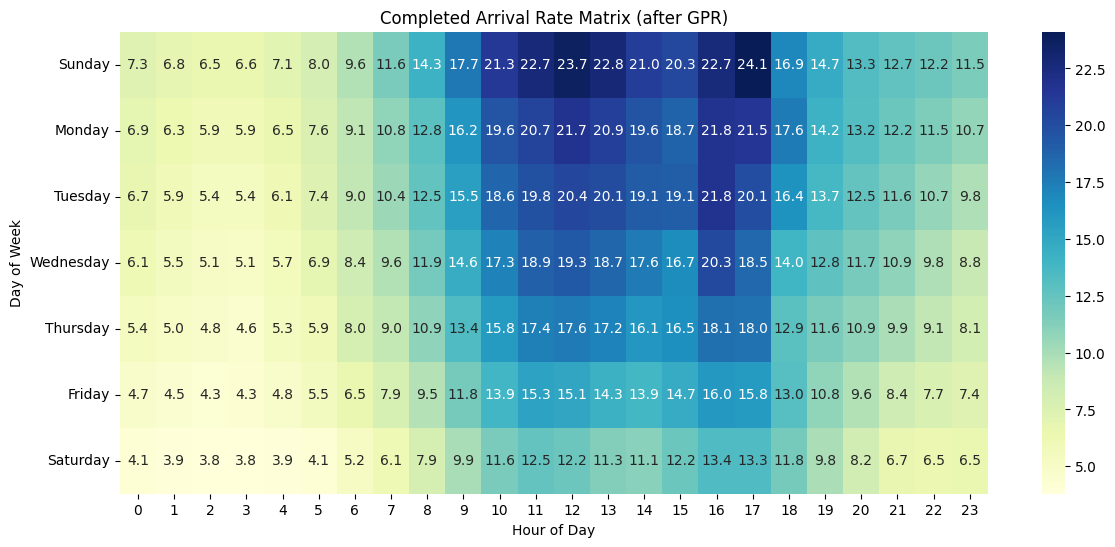

In [13]:
plt.figure(figsize=(14, 6))
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
arrival_rate_matrix_filled_sklearn.index = weekday_names

sns.heatmap(arrival_rate_matrix_filled_sklearn, annot=True, fmt=".1f", cmap="YlGnBu")

plt.title("Completed Arrival Rate Matrix (after GPR)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


The MSE is:  2.4794660319260533


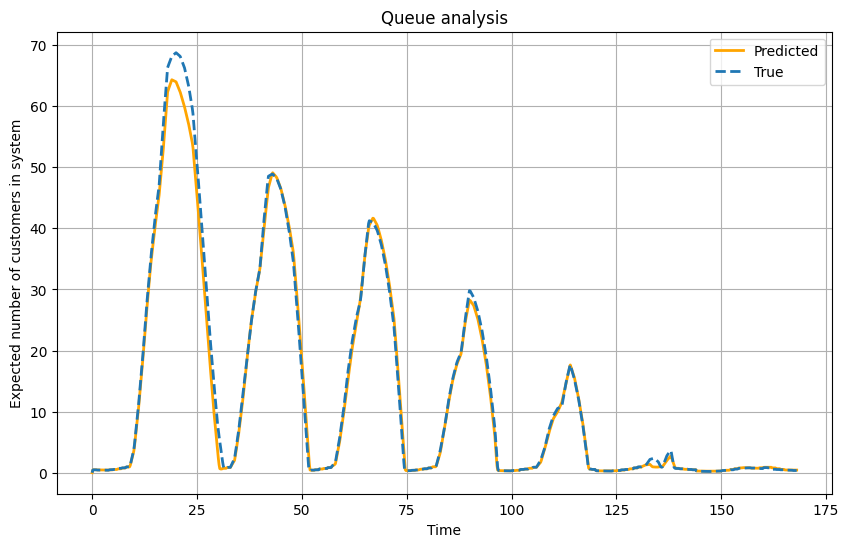

In [17]:
n_true = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Base_project/n_true.pkl")

plot_results(df_res_final, n_true)

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

### שלב שני: חיזוי ערכים חסרים בעזרת רגרסיה גאוסית (GPR)

בשלב זה מטרתנו הייתה **להשלים את התאים החסרים** במטריצת \\( \lambda_{d,h} \\) באמצעות רגרסיה גאוסית (Gaussian Process Regression), תוך בחינת גרעינים שונים ובחירת הפרמטרים האופטימליים.

---

#### שלב 1: בחינת גרעינים (Kernels)
- הגדרנו מספר גרעינים אפשריים, כולל:
  - RBF  
  - RationalQuadratic  
  - DotProduct  
  - WhiteKernel  
  - Matern עם פרמטרי \\( \nu = 1.5 \\) ו־\\( \nu = 2.5 \\)
- עבור כל גרעין:
  1. אימנו מודל GPR על הנתונים הידועים בלבד.
  2. השלמנו את הערכים החסרים במטריצה באמצעות חיזוי.
  3. חישבנו שגיאת MSE על סמך אומדן של מספר מטופלים בפועל (n_true).
- בחרנו את הגרעין עם ה־MSE הנמוך ביותר להמשך.

---

#### שלב 2: חיפוש רשת (Grid Search) לפרמטרים

<div dir="rtl"

לאחר שנבחר הגרעין המתאים (Matern), ביצענו **חיפוש רשת** על שלושה פרמטרים:
- `length_scale` ∈ {1.0, 2.5, 4.0, 6.0}  
- `constant_value` ∈ {0.5, 1.0, 2.0}  
- `alpha` ∈ {1e−6, 1e−4, 1e−2}  

<div dir="rtl"

בכל איטרציה של קומבינציה:
1. אימנו את המודל.
2. חיזינו את התאים החסרים בלבד.
3. חישבנו את MSE באמצעות סימולציה של n(t) דרך מודל מבוסס ODE.

---

#### שלב 3: השלמה סופית של מטריצת \\( \lambda_{d,h} \\)
- לקחנו את הפרמטרים האופטימליים שנמצאו ב־Grid Search.
- אימנו מודל GPR על הנתונים הידועים.
- חיזינו רק את הערכים החסרים.
- יצרנו מטריצה שלמה `arrival_rate_matrix_filled` — שבה התאים הידועים נשמרו והתאים החסרים מולאו בחיזוי המודל.

---

#### תוצאה סופית:

<div dir="rtl">

<div dir="rtl"

המטריצה המלאה \\( \lambda_{d,h} \\) כוללת את כלל 168 התאים — 24 שעות × 7 ימים — כאשר כל תא מכיל את קצב ההגעה המשוער, בין אם על סמך נתוני אמת או על סמך חיזוי רגרסיבי.  
בהמשך נוכל להשתמש במטריצה זו לביצוע סימולציות נוספות של זרימת מטופלים לאורך השבוע.

</div>
</div>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

## 🔎 למה מתקבלות תוצאות שונות בין PyMC ל־sklearn?
<div dir="rtl"

בעת השוואת ביצועי מודל Gaussian Process בין שתי ספריות נפוצות – `PyMC` הבייסיאנית ו־`sklearn` הפונקציונלית –  
התברר ש־**גרעין Matern32** סיפק את התוצאה **הגרועה ביותר** ב־PyMC (MSE ≈ 6.1),  
בעוד שב־`sklearn` הוא הניב את **התוצאה הטובה ביותר** (MSE ≈ 2.1).  

---
###  הבדלים מהותיים בין PyMC ל־sklearn:

<div dir="rtl"

 **שיטת התאמה שונה להיפר־פרמטרים**:

<div dir="rtl"
    
   - `sklearn` מבצע **אופטימיזציה דטרמיניסטית** למציאת ערכי פרמטרים מיטביים (MLE).
   - `PyMC` מבצע **דגימה בייסיאנית מלאה (MCMC)** ליצירת פוסטריור – לא בהכרח בוחר את המינימום של MSE, אלא מתאר את אי־הוודאות סביב כל חיזוי.

<div dir="rtl"

**שיטת החיזוי**:

<div dir="rtl"

   - ב־`sklearn` מקבלים חיזוי דטרמיניסטי ישיר (הערך הכי טוב לפי המודל).
   - ב־`PyMC`, מקבלים **תחזית פוסטריורית**, לרוב כממוצע של אלפי דגימות – מה שמקהה את הדיוק אם ההתפלגות לא ממורכזת היטב.

---

## 🎯 מעבר לגרעין ExpQuad

<div dir="rtl"

לאחר שנמצא כי `Matern32` הביא ל־MSE גבוה יחסית ב־PyMC,  
הוחלט **לעבור לגרעין אחר – `ExpQuad` (המכונה גם RBF או Squared Exponential)** – מכמה סיבות:


1. **רגיש פחות ל־length_scale קיצוני**:  

<div dir="rtl"

   ExpQuad מניח שינוי חלק ואיטי בפונקציה – מה שמתאים לדפוס ההגעה לאורך שעות וימים.

2. **ביצועים חזקים גם ב־`sklearn` וגם ב־`PyMC`**:  

<div dir="rtl"

   בהתנסות, גרעין זה הפיק תוצאות הרבה יותר טובות מ־Matern32, עם MSE ≈ 4.1 בלבד.

3. **התכנסות טובה יותר ב־PyMC**:  

<div dir="rtl"

   פחות סיכוי ל־divergences, התנהגות חלקה של הפוסטריור.


In [18]:
# === Scale the inputs for numerical stability ===
scaler = StandardScaler()
X_known_scaled = scaler.fit_transform(X_known)
X_missing_scaled = scaler.transform(X_missing)

with pm.Model() as gpr_model_eq:
    # Priors for kernel hyperparameters
    ℓ = pm.Gamma("ℓ", alpha=2.5, beta=0.5)       # lengthscale > 0
    η = pm.HalfNormal("η", sigma=15.0)           # output scale
    σ = pm.HalfNormal("σ", sigma=5)            # noise std

    # ExpQuad kernel (a.k.a. RBF)
    kernel = η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ℓ)

    # GP regression with Gaussian noise
    gp = pm.gp.Marginal(cov_func=kernel)
    y_ = gp.marginal_likelihood("y", X=X_known_scaled, y=y_known, noise=σ)

    # Sample from posterior over hyperparameters
    trace_rbf = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# Optional: View summary of the trace
az.summary(trace_rbf, round_to=2)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η,12.08,3.50,7.07,19.12,0.08,0.08,2179.94,2053.60,1.0
σ,1.27,0.12,1.03,1.49,0.00,0.00,2266.93,2495.77,1.0
ℓ,1.32,0.14,1.05,1.57,0.00,0.00,1972.41,2171.46,1.0


In [19]:
# === Predict missing points ===
with gpr_model_eq:
    # Predictive mean and samples for missing X points
    f_pred = gp.conditional("f_pred", X_missing_scaled)

    # Sample from the posterior predictive distribution
    posterior_predictive_rbf = pm.sample_posterior_predictive(
        trace_rbf,
        var_names=["f_pred"],
        random_seed=42
    )

Output()

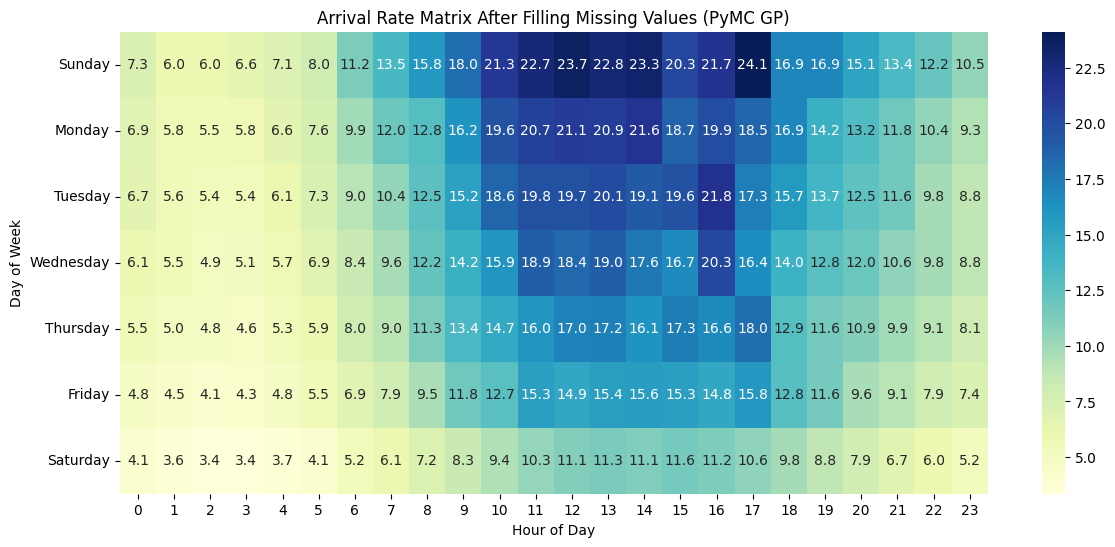

In [20]:
# Step 1 – Extract posterior samples and flatten chain dimension
raw_samples = posterior_predictive_rbf.posterior_predictive["f_pred"].values  # shape: (chains, draws, n_missing)
posterior_samples = raw_samples.reshape(-1, raw_samples.shape[-1])       # shape: (chains × draws, n_missing)

# Step 2 – Compute the mean prediction for each missing cell
pred_mean_flat = posterior_samples.mean(axis=0)  # shape: (n_missing,)

# Step 3 – Create a copy of the original matrix
arrival_rate_matrix_filled = arrival_rate_matrix.copy()

# Step 4 – Find missing value positions
missing_indices = np.argwhere(arrival_rate_matrix.isna().values)

# Step 5 – Fill only the missing cells
for i, (row, col) in enumerate(missing_indices):
    arrival_rate_matrix_filled.iat[row, col] = pred_mean_flat[i]

df_res_final_pymc = arrival_rate_matrix_filled.stack().reset_index()
df_res_final_pymc.columns = ["day", "hour", "rate"]

# Step 6 – Display the filled matrix as a heatmap
plt.figure(figsize=(14, 6))
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
arrival_rate_matrix_filled.index = weekday_names

sns.heatmap(arrival_rate_matrix_filled, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Arrival Rate Matrix After Filling Missing Values (PyMC GP)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


The MSE is:  4.229744514185908


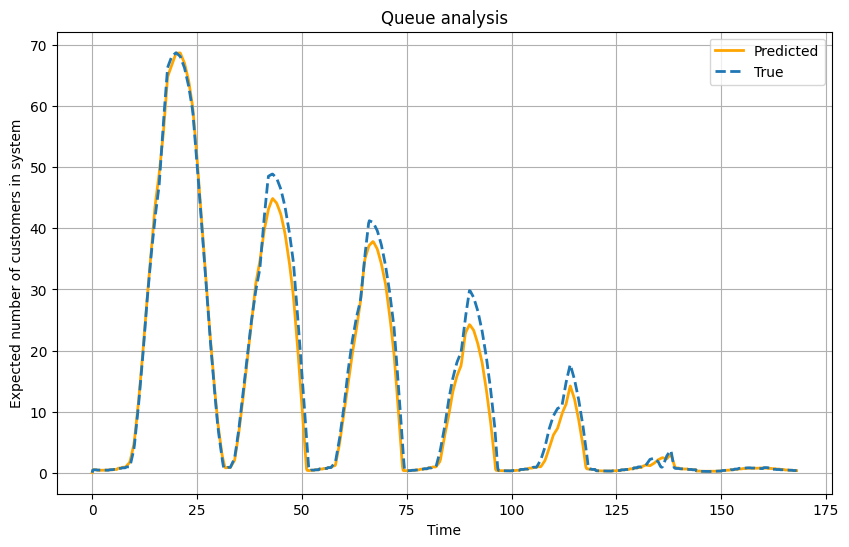

In [21]:
plot_results(df_res_final_pymc, n_true)

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 3

</div>

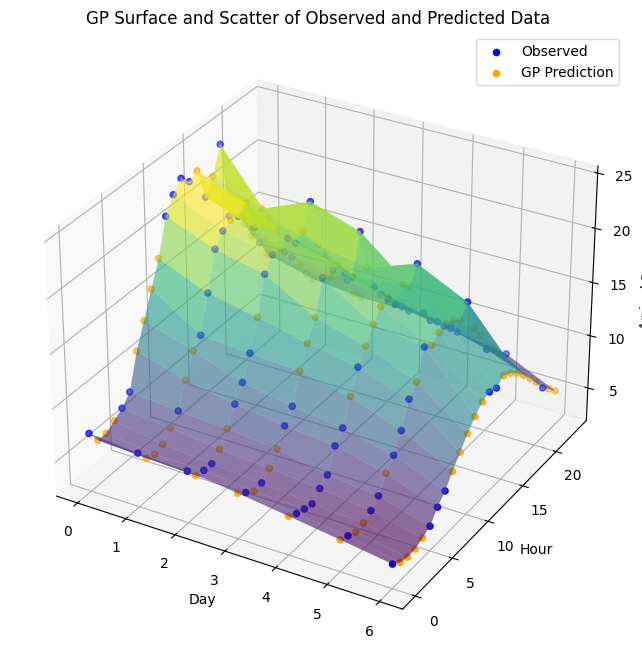

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Coordinates for plotting
days = np.arange(7)
hours = np.arange(24)
grid_days, grid_hours = np.meshgrid(days, hours, indexing="ij")

# Filled matrix (used for surface)
Z_surface = arrival_rate_matrix_filled.values.astype(float)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# a. Known data (blue dots)
ax.scatter(X_known[:, 0], X_known[:, 1], y_known, color='blue', label='Observed')

# b. Predicted missing data (orange dots)
ax.scatter(X_missing[:, 0], X_missing[:, 1], pred_mean_flat, color='orange', label='GP Prediction')

# c. Surface of GP
ax.plot_surface(grid_days, grid_hours, Z_surface, cmap='viridis', alpha=0.6)

ax.set_xlabel('Day')
ax.set_ylabel('Hour')
ax.set_zlabel('Arrival Rate')
ax.set_title('GP Surface and Scatter of Observed and Predicted Data')
ax.legend()
plt.show()


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 4

In [23]:
# Transform to scaled coordinates
point = scaler.transform([[6, 18]])

# תנבא מחדש לנקודה הזאת (תוך שימוש באותו trace)
with gpr_model_eq:
    f_pred_specific = gp.conditional("f_pred_specific", Xnew=point)
    pred_samples_specific = pm.sample_posterior_predictive(
        trace_rbf, var_names=["f_pred_specific"], random_seed=42
    )

samples = pred_samples_specific.posterior_predictive["f_pred_specific"].values.reshape(-1)

# הסתברות בין 9 ל-10
prob_9_to_10 = ((samples >= 9) & (samples <= 10)).mean()
print(f"Estimated probability: {prob_9_to_10:.4f}")


Output()

Estimated probability: 0.3797


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 5

In [24]:
# Scale both inputs
monday_points = scaler.transform([[1, 18], [1, 19]])

with gpr_model_eq:
    f_pred_monday = gp.conditional("f_pred_monday", Xnew=monday_points)
    pred_samples_monday = pm.sample_posterior_predictive(
        trace_rbf, var_names=["f_pred_monday"], random_seed=42
    )

samples_monday = pred_samples_monday.posterior_predictive["f_pred_monday"].values.reshape(-1, 2)

for i, hour in enumerate([18, 19]):
    mu = samples_monday[:, i].mean()
    sigma = samples_monday[:, i].std()
    print(f"Hour {hour}: μ = {mu:.2f}, σ = {sigma:.2f}")


Output()

Hour 18: μ = 16.88, σ = 0.62
Hour 19: μ = 15.14, σ = 0.63


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 6

In [25]:
# Scale input points
sun_points = scaler.transform([[0, 7], [0, 8], [0, 19]])

with gpr_model_eq:
    f_pred_sun = gp.conditional("f_pred_sun", Xnew=sun_points)
    pred_samples_sun = pm.sample_posterior_predictive(
        trace_rbf, var_names=["f_pred_sun"], random_seed=42
    )

samples_sun = pred_samples_sun.posterior_predictive["f_pred_sun"].values.reshape(-1, 3)

# Correlations
corr_7_8 = np.corrcoef(samples_sun[:, 0], samples_sun[:, 1])[0, 1]
corr_7_19 = np.corrcoef(samples_sun[:, 0], samples_sun[:, 2])[0, 1]

print(f"Corr(07–08 vs 08–09) = {corr_7_8:.2f}")
print(f"Corr(07–08 vs 19–20) = {corr_7_19:.2f}")

# הסבר על ההיגיון:
larger = "07–08 vs 08–09" if corr_7_8 > corr_7_19 else "07–08 vs 19–20"
print(f"➡️ The stronger correlation is between: {larger}")


Output()

Corr(07–08 vs 08–09) = 0.97
Corr(07–08 vs 19–20) = -0.05
➡️ The stronger correlation is between: 07–08 vs 08–09


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

##  סיכום שאלות 3–6 — רגרסיה גאוסית בייסיאנית עם PyMC

###  רקע
<div dir="rtl"
    
השתמשנו במודל `gp.Marginal` של PyMC עם גרעין מסוג **ExpQuad (RBF)** כדי להשלים ערכים חסרים במטריצת קצב הגעה שבועית בגודל 7×24.  
גרעין זה הניב שגיאת ריבוע ממוצעת (MSE) טובה בהרבה מ־Matern ב־PyMC (למרות שב־`sklearn` גרעין Matern דווקא הצטיין).  
לאחר בניית המודל ודגימת הפוסטריור, ענינו על שאלות מתקדמות באמצעות דגימה פוסטריורית חוזרת (posterior predictive sampling).

---

##  שאלה 3 — תרשים תלת־ממדי של נתונים וחיזויים

<div dir="rtl"
    
בנינו תרשים תלת־ממדי הכולל:

-  **נקודות אמת** – הערכים שנמדדו בפועל
-  **נקודות חסרות שהושלמו** – חיזויים שנוצרו מהמוצר הפוסטריורי
-  **משטח חלק** – המטריצה המלאה לאחר חיזוי כל הערכים

<div dir="rtl"
    
✅ התרשים מאשר ויזואלית שהמודל השלים ערכים בצורה רציפה וסבירה, בהתאם למבנה שבועי־שעותי.

---

## שאלה 4 — מה ההסתברות שקצב ההגעה בשבת בין 18:00 ל־19:00 יהיה בין 9 ל־10?

<div dir="rtl"
    
בדקנו את הדגימות הפוסטריוריות לנקודה (שבת, 18:00) וחישבנו את השכיחות היחסית של ערכים בטווח [9, 10]:

```python
prob_9_to_10 = ((samples >= 9) & (samples <= 10)).mean()
```
<div dir="rtl"

✅ ההסתברות המשוערת: 0.3797
כלומר יש כ־38% הסתברות שקצב ההגעה בשעה הזו יהיה בין 9 ל־10 מטופלים לשעה.


## שאלה 5 — מהי ההתפלגות הגאוסית עבור יום שני בין 18:00 ל־20:00?

<div dir="rtl"

שלפנו את הדגימות הפוסטריוריות לנקודות:

- יום שני, 18:00–19:00 (`day=1, hour=18`)
- יום שני, 19:00–20:00 (`day=1, hour=19`)

<div dir="rtl"

וחישבנו ממוצע וסטיית תקן של הפוסטריור.

<div dir="rtl"

✅ התוצאה:

- **18:00–19:00** → μ = 16.88, σ = 0.62
- **19:00–20:00** → μ = 15.14, σ = 0.63

## שאלה 6 — קורלציה בין שעות שונות ביום ראשון

<div dir="rtl"

השווינו בין הדגימות הפוסטריוריות עבור שלוש נקודות זמן:

- 07:00–08:00 (יום ראשון)
- 08:00–09:00 (יום ראשון)
- 19:00–20:00 (יום ראשון)

<div dir="rtl"

וחישבנו מתאמים:

- 07–08 מול 08–09: 0.97
- 07–08 מול 19–20: −0.05

<div dir="rtl"

➡️ **הקורלציה החזקה יותר היא בין 07–08 ל־08–09**

## הסבר:

<div dir="rtl"

תוצאה זו הגיונית מאוד:

- שעות סמוכות בבוקר לרוב מושפעות מאותו דפוס תפעולי (פתיחת מרפאה, גלי הגעה).
- שעות ערב משקפות פעילות אחרת לגמרי, ולכן ייתכן חוסר קורלציה ואף קורלציה שלילית עם הבוקר.

## Part 3:

### This is a competative part.

### We have completed the arrival rate predictions by now.

### Now we wish to use them for prediciting the Expected number of patients in the system as a function of time.

### All you need to do is create a dataframe with results in the following manner.

### Upload n_true and df_res.

### n_true is the true expceted number of customers in the system.

### df_res is a dataframe with three columns: hour, day and rate. Currently the rate column is with zeros, you need to fill in your predicted rates from the GP regression and then execute the function plot_results.

### The function will visulize your estimated expected number of customers as a function of time agaisnt the true values (from n_true).

### The fucntion will also print the MSE, the team with lowest MSE wins.

### The bonous points are as follows:

### $1^{st}$ place 5 points bonus.
### $2^{nd}$ place  3 points bonus.
### $3^{rd}$ place  1 point bonus.

## May the best team win!!

In [ ]:
## Your code here for competing df_res


### Currently all the rates are 0 values, you need to fill in  your predictions.



### The MSE is:  2.4794660319260533

The MSE is:  2.479469701300308


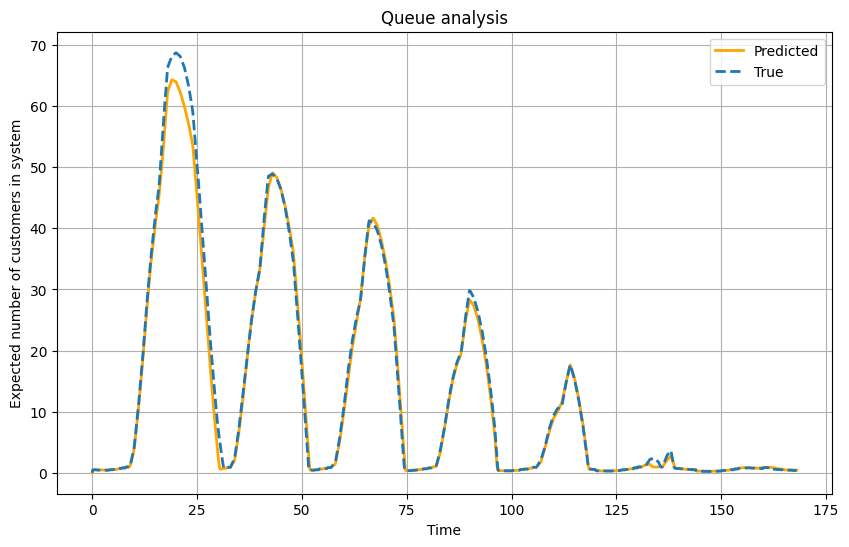

In [ ]:
plot_results(df_res, n_true)